<a href="https://colab.research.google.com/github/donald-ye/nyc-marathon-data-mining/blob/main/notebooks/data_mining__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mining the Marathon

CISC 4631 Final Project

Paulina Delabra Serrano, Jane Warren, and Donald Ye

Due Dec. 5, 2025

---

**Data Mining**

This notebook:
- Imports the cleaned data from a csv
- Performs regression to predict final marathon time, using three different regression models to compare performance
- Performs clustering to investigate "types of runners"
- Evaluates all techniques used
- Provides visualizations of our results

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the data in
import pandas as pd
final_df = pd.read_csv('/content/drive/MyDrive/all_runners_2025.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
final_df.isna().sum()

,0
RunnerID,0
splitCode,0
speed,0
distance,0
RunnerName,0
OverallPlace,0
Gender,19
Age,0
City,326
Country,326


**Technique #1: Regression**

Here, we use regression to predict each runner's finish time based on their first-half splits, age, gender, and nationality.  

In [ ]:
# organize the feature and target cols in a copied df

first_half_pace_cols = [
    'split_pace_5K', 'split_pace_10K', 'split_pace_15K',
    'split_pace_20K', 'split_pace_HALF'
]

df = final_df.copy()

# fade and ratio between consecutive splits
for i in range(len(first_half_pace_cols)-1):
    col_prev = first_half_pace_cols[i]
    col_next = first_half_pace_cols[i+1]
    df[f'fade_{col_prev}_{col_next}'] = df[col_next] - df[col_prev]
    df[f'ratio_{col_next}_{col_prev}'] = df[col_next] / df[col_prev]

fade_cols = [c for c in df.columns if c.startswith('fade_')]
ratio_cols = [c for c in df.columns if c.startswith('ratio_')]

# adding some more statistical features to try and improve model performance
df['avg_pace_first_half'] = df[first_half_pace_cols].mean(axis=1)
df['cv_first_half'] = df[first_half_pace_cols].std(axis=1) / df['avg_pace_first_half']
df['min_pace_first_half'] = df[first_half_pace_cols].min(axis=1)
df['max_pace_first_half'] = df[first_half_pace_cols].max(axis=1)
df['range_pace_first_half'] = df['max_pace_first_half'] - df['min_pace_first_half']

feature_cols = first_half_pace_cols + fade_cols + ratio_cols + \
               ['avg_pace_first_half','cv_first_half','min_pace_first_half',
                'max_pace_first_half','range_pace_first_half',
                'Age','Gender','Country']

target_col = 'OverallTime'

In [ ]:
# assign X and y
X = df[feature_cols]
y = df[target_col]

In [ ]:
# split into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # we use test size 0.2

a. GradientBoostingRegressor

In [ ]:
# add a bit of preprocessing to deal with NaN values (GradientBoostingRegressor cannot take any NaNs)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# encode the variables
numeric_cols = [c for c in first_half_pace_cols] + ['Age']
categorical_cols = ['Gender', 'Country']

numeric_transformer_grad = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_grad = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_grad = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_grad, numeric_cols),
        ("cat", categorical_transformer_grad, categorical_cols)
    ]
)

# initialize the model pipeline!

model_grad = Pipeline(steps=[
    ('preprocess', preprocessor_grad),
    ('regressor', GradientBoostingRegressor())
])

In [ ]:
# fit the model
model_grad.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['split_pace_5K',
                                                   'split_pace_10K',
                                                   'split_pace_15K',
                                                   'split_pace_20K',
                                                   'split_pace_HALF', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Country'])])),
                ('regressor', GradientBoostingRegressor())])

In [ ]:
# running inference on the test set and taking root mean squared error
from sklearn.metrics import mean_squared_error
import numpy as np

preds_grad = model_grad.predict(X_test)
rmse_grad = np.sqrt(mean_squared_error(y_test, preds_grad))

print("RMSE for GradientBoostingRegressor (seconds):", rmse_grad)
print("RMSE for GBR (minutes):", rmse_grad / 60)


RMSE for GradientBoostingRegressor (seconds): 857.7252704724581
RMSE for GBR (minutes): 14.295421174540968


In [ ]:
model_grad['regressor'].feature_importances_


array([1.55445013e-03, 1.85137821e-02, 3.33177265e-01, 2.69586188e-01,
       3.74296006e-01, 1.37180183e-04, 1.76107958e-03, 6.58699259e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.02154550e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.30717748e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
# now we can see the feature importances.
feature_names_grad = model_grad.named_steps['preprocess'].get_feature_names_out()
importances_grad = model_grad.named_steps['regressor'].feature_importances_
importances_grad_percent = (importances_grad / importances_grad.sum()) * 100

for name, val in sorted(zip(feature_names_grad, importances_grad_percent), key=lambda x: x[1], reverse=True):
    print(f"{name}: {val:.4f}")

num__split_pace_HALF: 37.4296
num__split_pace_15K: 33.3177
num__split_pace_20K: 26.9586
num__split_pace_10K: 1.8514
cat__Gender_M: 0.1761
num__split_pace_5K: 0.1554
cat__Gender_W: 0.0659
cat__Country_MNG: 0.0171
num__Age: 0.0137
cat__Country_USA: 0.0049
cat__Country_GRL: 0.0042
cat__Country_ITA: 0.0024
cat__Country_AUS: 0.0010
cat__Country_FRA: 0.0008
cat__Country_MYS: 0.0005
cat__Country_THA: 0.0005
cat__Country_JPN: 0.0000
cat__Gender_X: 0.0000
cat__Country_ABW: 0.0000
cat__Country_AGO: 0.0000
cat__Country_ALB: 0.0000
cat__Country_AND: 0.0000
cat__Country_ARE: 0.0000
cat__Country_ARG: 0.0000
cat__Country_ARM: 0.0000
cat__Country_ATF: 0.0000
cat__Country_ATG: 0.0000
cat__Country_AUT: 0.0000
cat__Country_BEL: 0.0000
cat__Country_BGR: 0.0000
cat__Country_BHS: 0.0000
cat__Country_BLR: 0.0000
cat__Country_BMU: 0.0000
cat__Country_BOL: 0.0000
cat__Country_BRA: 0.0000
cat__Country_BRB: 0.0000
cat__Country_BWA: 0.0000
cat__Country_Bos: 0.0000
cat__Country_CAN: 0.0000
cat__Country_CHE: 0.0000

b. HistGradientBoostingRegressor

In [ ]:
# trying to improve performance using pace and some other engineered features

from sklearn.ensemble import HistGradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reinitialize the transformers.

numeric_transformer_hist = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_hist = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_hist = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_hist, numeric_cols),
        ('cat', categorical_transformer_hist, categorical_cols)
    ]
)

model_hist = Pipeline(steps=[
    ('preprocessor', preprocessor_hist),
    ('regressor', HistGradientBoostingRegressor())
])

# fit model
model_hist.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['split_pace_5K',
                                                   'split_pace_10K',
                                                   'split_pace_15K',
                                                   'split_pace_20K',
                                                   'split_pace_HALF', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Country'])])),
                ('regressor', HistGradientBoostingRegressor())])

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

# transform data, get regressor and feature names
X_train_trans = model_hist.named_steps['preprocessor'].transform(X_train)
X_test_trans  = model_hist.named_steps['preprocessor'].transform(X_test)

reg = model_hist.named_steps['regressor']

feature_names = model_hist.named_steps['preprocessor'].get_feature_names_out()

print("matching lengths check:")
print("X_test_trans:", X_test_trans.shape)
print("len(feature_names):", len(feature_names))

# compute permutation importance
perm = permutation_importance(
    reg,
    X_test_trans,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

print("Permutation result count:", perm.importances_mean.shape[0])


# make sure importances match number of names
assert perm.importances_mean.shape[0] == len(feature_names), \
    "importances do not equal features. double check the model initialization."

# build labeled series
feature_importances_hist = pd.Series(
    perm.importances_mean,
    index=feature_names
).sort_values(ascending=False)

print(feature_importances_hist)

# convert permutation importances to percentages
positive_importances = feature_importances_hist[feature_importances_hist > 0]
total_importance = positive_importances.sum()
feature_importances_hist_percent = (positive_importances / total_importance) * 100
feature_importances_hist_percent = feature_importances_hist_percent.sort_values(ascending=False)

print(feature_importances_hist_percent)

matching lengths check:
X_test_trans: (11279, 139)
len(feature_names): 139
Permutation result count: 139
num__split_pace_HALF    1.144239e+00
num__split_pace_15K     1.887206e-01
num__split_pace_10K     7.329349e-02
num__split_pace_20K     3.252663e-02
num__split_pace_5K      1.831846e-03
cat__Gender_M           1.795963e-03
cat__Gender_W           1.540016e-03
cat__Country_USA        4.917775e-04
num__Age                8.103024e-05
cat__Country_FRA        4.362675e-05
cat__Country_AUS        1.839213e-05
cat__Country_PER        1.245761e-05
cat__Country_SWE        1.199074e-05
cat__Country_THA        8.449422e-06
cat__Country_NOR        6.642922e-06
cat__Country_NZL        6.531547e-06
cat__Country_KOR        4.163849e-06
cat__Country_NIR        3.748445e-06
cat__Country_IDN        2.274194e-06
cat__Country_MEX        2.177369e-06
cat__Country_POL        2.132602e-06
cat__Country_GBR        2.127719e-06
cat__Country_CHE        2.028061e-06
cat__Country_VEN        1.472951e-06
cat__Co

In [ ]:
# evaluate so we can compare
import numpy as np
from sklearn.metrics import mean_squared_error

preds_hist = model_hist.predict(X_test)
rmse_hist = np.sqrt(mean_squared_error(y_test, preds_hist))
print("RMSE for Hist. (seconds):", rmse_hist)
print("RMSE for Hist. (minutes):", rmse_hist / 60)


RMSE for Hist. (seconds): 806.5556248767803
RMSE for Hist. (minutes): 13.442593747946338


c. CatBoostRegressor (not native to CoLab, so we install)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool

cat_features = ['Gender','Country']

for col in cat_features:
    most_freq = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(most_freq).astype(str)
    X_test[col] = X_test[col].fillna(most_freq).astype(str)

# create catboost pool (handles categorical features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# initialize model
model_cat = CatBoostRegressor(
    iterations=1000,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# Fit model
model_cat.fit(train_pool)

# predict and evaluate. here we see that this is the best-performing model of the three!
preds_cat = model_cat.predict(test_pool)
rmse_cat = np.sqrt(mean_squared_error(y_test, preds_cat))
print("RMSE for Cat. (seconds):", rmse_cat)
print("RMSE for Cat. (minutes):", rmse_cat/60)

# feature importances
feature_importances_cat = model_cat.get_feature_importance(train_pool)
importance_df_cat = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_cat})\
                    .sort_values('importance', ascending=False)
print(importance_df_cat.head(15))


Learning rate set to 0.074741
0:	learn: 3594.0449008	total: 75.8ms	remaining: 1m 15s
100:	learn: 753.7379431	total: 5.19s	remaining: 46.2s
200:	learn: 736.1516060	total: 11.7s	remaining: 46.6s
300:	learn: 724.0101193	total: 17.5s	remaining: 40.6s
400:	learn: 712.7371329	total: 22.9s	remaining: 34.2s
500:	learn: 703.5113754	total: 27.6s	remaining: 27.5s
600:	learn: 695.9939629	total: 29.8s	remaining: 19.8s
700:	learn: 688.8257552	total: 32s	remaining: 13.7s
800:	learn: 682.1619970	total: 34.2s	remaining: 8.51s
900:	learn: 676.0772856	total: 36.5s	remaining: 4.01s
999:	learn: 670.2447573	total: 40.4s	remaining: 0us
RMSE for Cat. (seconds): 738.2867981175315
RMSE for Cat. (minutes): 12.304779968625525
                                 feature  importance
16                   max_pace_first_half   29.422549
4                        split_pace_HALF   21.904281
13                   avg_pace_first_half   11.871084
3                         split_pace_20K    9.835608
15                   min_pa

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# catboost
mae_cat = mean_absolute_error(y_test, preds_cat)
r2_cat = r2_score(y_test, preds_cat)
print("CatBoost - MAE (seconds):", mae_cat)
print("CatBoost - MAE (minutes):", mae_cat / 60)
print("CatBoost - R²:", r2_cat)

# hist.
mae_hist = mean_absolute_error(y_test, preds_hist)
r2_hist = r2_score(y_test, preds_hist)
print("HistGB - MAE (seconds):", mae_hist)
print("HistGB - MAE (minutes):", mae_hist / 60)
print("HistGB - R²:", r2_hist)

# gradboost
mae_grad = mean_absolute_error(y_test, preds_grad)
r2_grad = r2_score(y_test, preds_grad)
print("GradBoost - MAE (seconds):", mae_grad)
print("GradBoost - MAE (minutes):", mae_grad / 60)
print("GradBoost - R²:", r2_grad)

CatBoost - MAE (seconds): 507.6696504862009
CatBoost - MAE (minutes): 8.461160841436682
CatBoost - R²: 0.9628255315185247
HistGB - MAE (seconds): 560.9516294129511
HistGB - MAE (minutes): 9.349193823549184
HistGB - R²: 0.9556326784466552
GradBoost - MAE (seconds): 612.7791799273637
GradBoost - MAE (minutes): 10.212986332122728
GradBoost - R²: 0.9498245849411515


Visualization

In [ ]:
import matplotlib.pyplot as plt

model_importances = {
    'HistGB': feature_importances_hist_percent,
    'CatBoost': feature_importances_cat,
    'GradientBoosting': importances_grad_percent
}

In [ ]:
import matplotlib.pyplot as plt

# Create a pandas Series for GradientBoostingRegressor feature importances
grad_fi_series = pd.Series(importances_grad_percent, index=feature_names_grad)

# Create a pandas Series for CatBoostRegressor feature importances
cat_fi_series = pd.Series(feature_importances_cat, index=X_train.columns)

# Update the model_importances dictionary with correctly formatted Series
model_importances = {
    'HistGB': feature_importances_hist_percent,
    'CatBoost': cat_fi_series,
    'GradientBoosting': grad_fi_series
}
print("Feature importances dictionary updated successfully.")

Feature importances dictionary updated successfully.


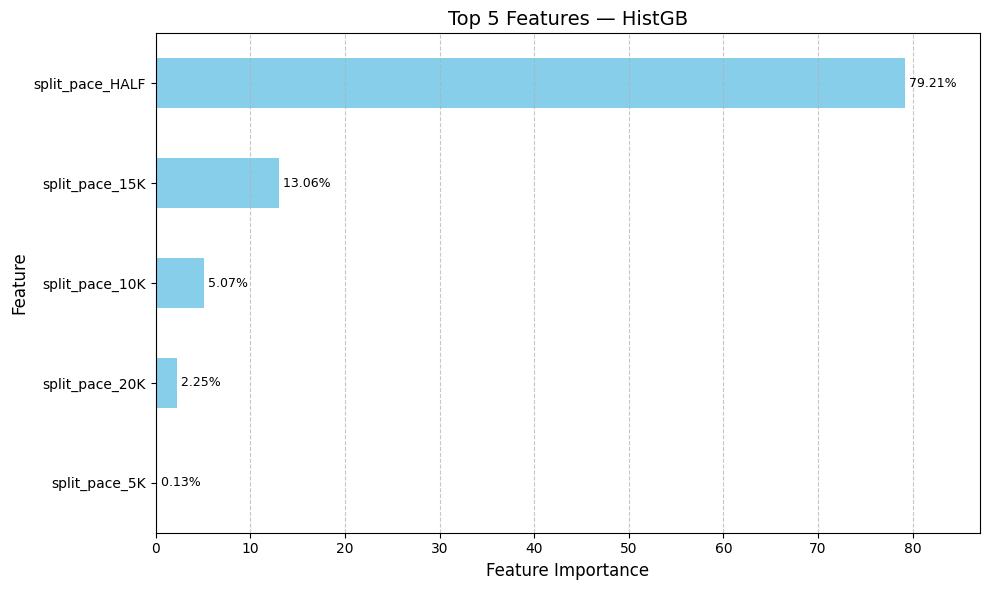

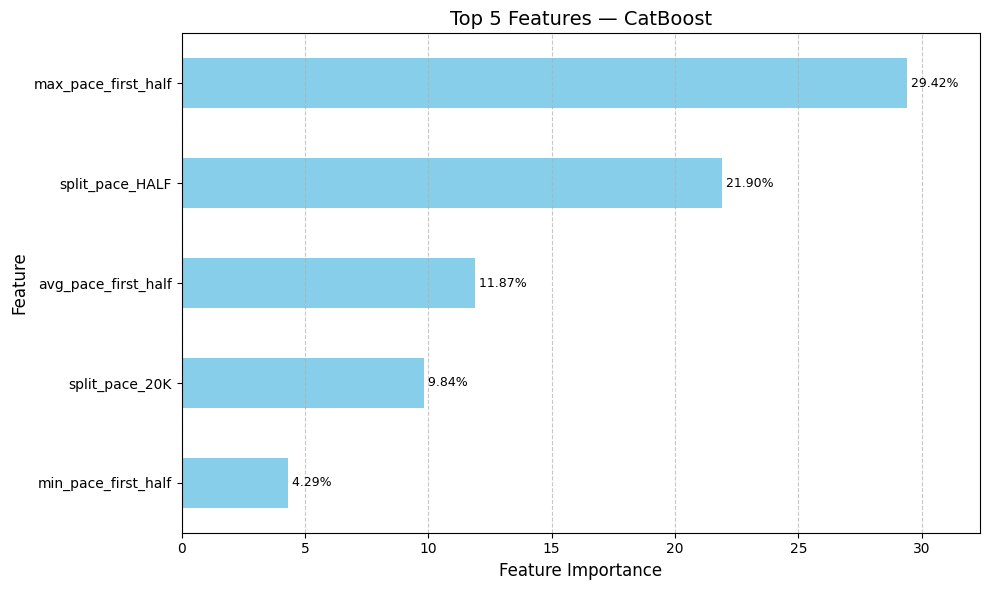

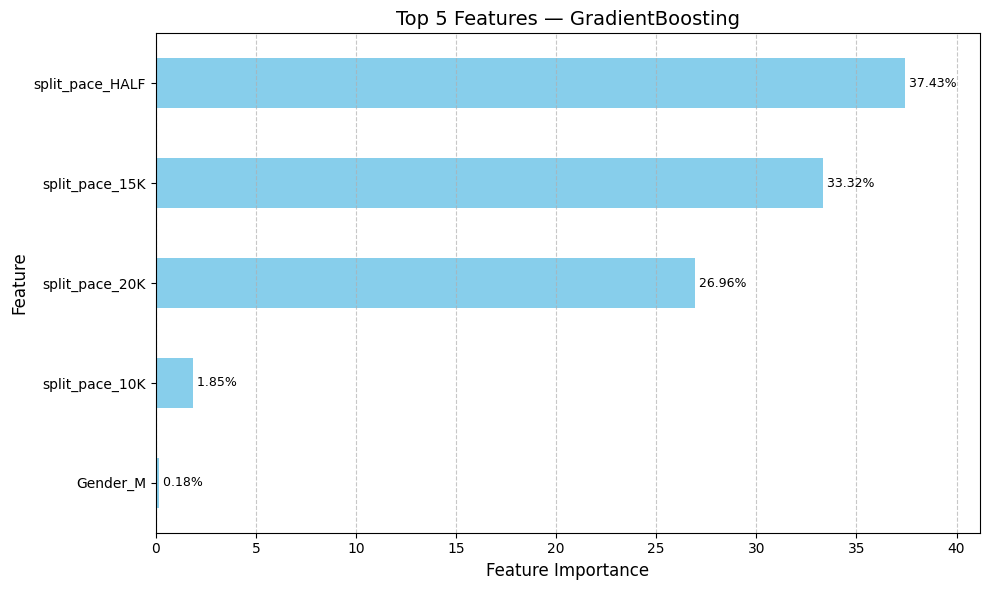

In [ ]:
top_n = 5

for model_name, fi in model_importances.items():
    # Sort the feature importances and take the top N
    fi_sorted = fi.sort_values(ascending=False).head(top_n)
    # remove prefixes for clarity
    fi_sorted.index = fi_sorted.index.str.replace('num__', '').str.replace('cat__', '')

    plt.figure(figsize=(10, max(6, 0.5 * top_n))) # Adjust figure size dynamically
    fi_sorted.plot(kind='barh', color='skyblue')
    plt.gca().invert_yaxis() # Display the most important feature at the top

    for i, value in enumerate(fi_sorted.values):
      plt.text(value, i, ' {:.2f}%'.format(value), va='center', fontsize=9)

    plt.xlim(0, fi_sorted.max() * 1.1)
    plt.title(f"Top {top_n} Features — {model_name}", fontsize=14)
    plt.xlabel("Feature Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()


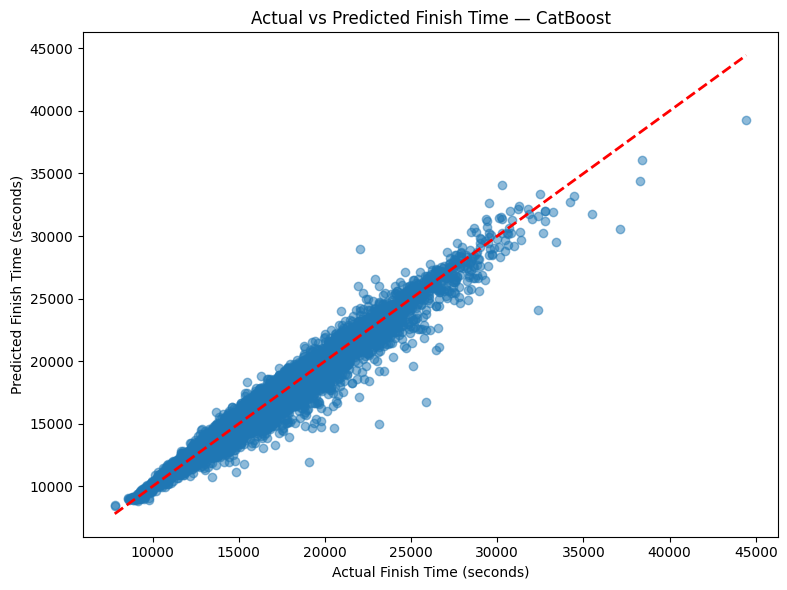

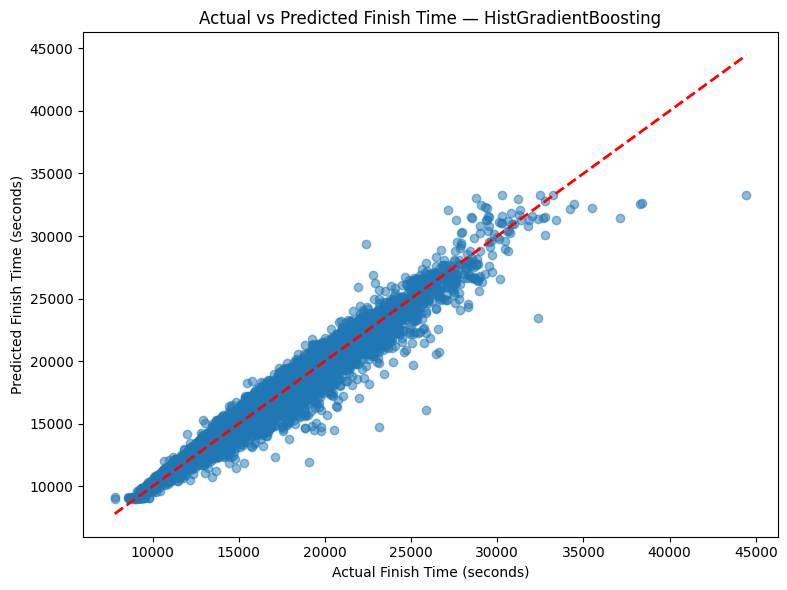

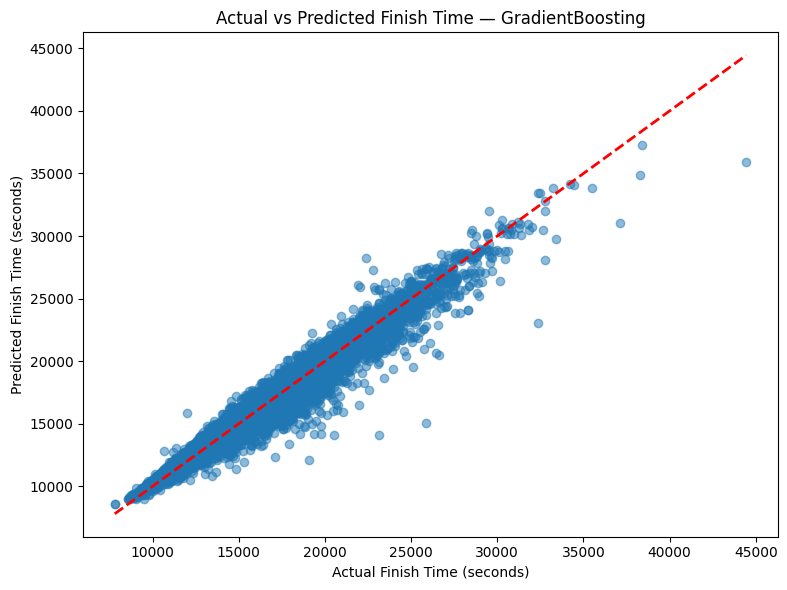

In [ ]:
# plot actual vs. predicted finish time for each model

model_preds = {
    "CatBoost": preds_cat,
    "HistGradientBoosting": preds_hist,
    "GradientBoosting": preds_grad
}


for model_name, preds in model_preds.items():
    plt.figure(figsize=(8,6))
    # plot actual vs predicted finish time
    plt.scatter(y_test, preds, alpha=0.5)
    # make the "perfect prediction" line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)
    plt.xlabel("Actual Finish Time (seconds)")
    plt.ylabel("Predicted Finish Time (seconds)")
    plt.title(f"Actual vs Predicted Finish Time — {model_name}")
    plt.tight_layout()
    plt.show()

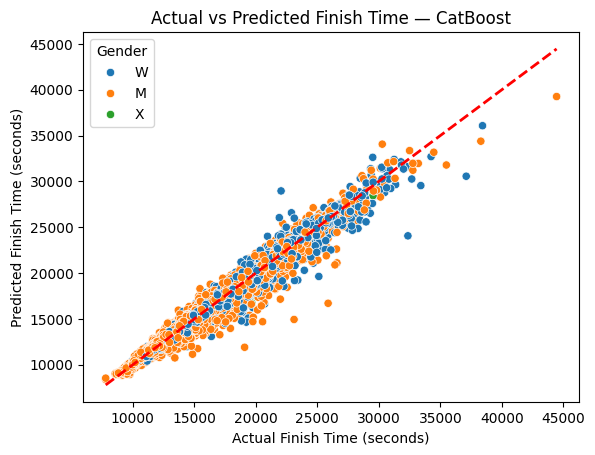

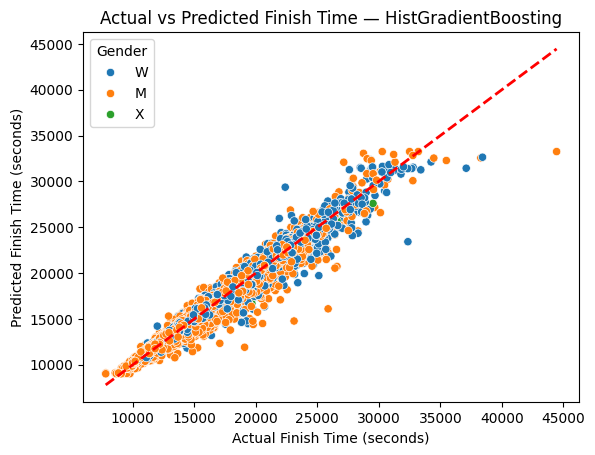

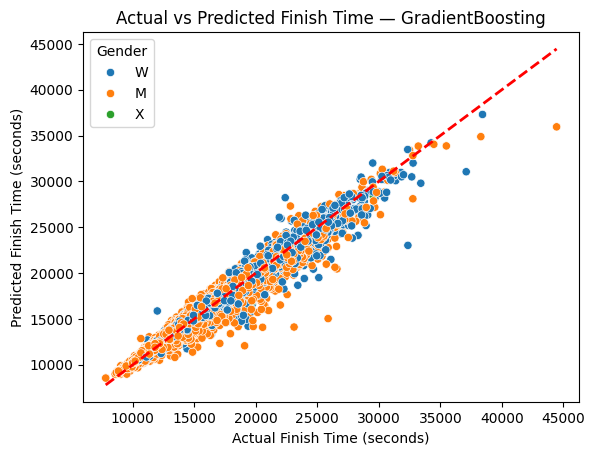

In [ ]:
# plot the same thing as above, but separated by gender

import seaborn as sns

for model_name, preds in model_preds.items():
  sns.scatterplot(x=y_test, y=preds, hue=X_test['Gender'])
  plt.plot([y_test.min(), y_test.max()],
          [y_test.min(), y_test.max()],
          'r--', lw=2)
  plt.xlabel("Actual Finish Time (seconds)")
  plt.ylabel("Predicted Finish Time (seconds)")
  plt.title(f"Actual vs Predicted Finish Time — {model_name}")
  plt.show()

**Technique #2: Clustering**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re

Helper Functions

In [ ]:
def get_distance(col_name):
    clean = col_name.replace('split_pace_', '').replace('split_time_', '')

    if clean == 'MAR':
        return 26.2
    if clean == 'HALF':
        return 13.1

    match_k = re.search(r'(\d+(\.\d+)?)K', clean)
    if match_k:
        km = float(match_k.group(1))
        return km * 0.621371  # convert km to miles

    match_m = re.search(r'(\d+(\.\d+)?)M', clean)
    if match_m:
        return float(match_m.group(1))

    return 0

In [ ]:
df = pd.read_csv('/content/all_runners_2025.csv')

pace_cols = [c for c in df.columns if 'split_pace' in c]
pace_cols_sorted = sorted(pace_cols, key=get_distance)
distances = [get_distance(c) for c in pace_cols_sorted]

print(f"found {len(pace_cols_sorted)} split points")

pace_data = df[pace_cols_sorted].copy()

# fill gaps between known splits
pace_data = pace_data.interpolate(method='linear', axis=1, limit_direction='both')
pace_data = pace_data.dropna()
df = df.loc[pace_data.index].copy()

runner_start_pace = pace_data.iloc[:, 0]

# normalize
pace_normalized = pace_data.div(runner_start_pace, axis=0)

reliable_splits = []
reliable_distances = []

for col, dist in zip(pace_cols_sorted, distances):
    missing_pct = (df[col].isna().sum() / len(df))
    avg_normalized = (df[col] / runner_start_pace).mean()

    if missing_pct < 0.4 and 0.5 < avg_normalized < 2.0:
        reliable_splits.append(col)
        reliable_distances.append(dist)
    else:
        if missing_pct >= 0.4:
            reason = f"{missing_pct*100:.1f}% missing data"
        else:
            reason = f"anomalous pace factor: {avg_normalized:.3f}"
        print(f"{col:30s} ({dist:5.2f} mi): {reason}")

pace_cols_sorted = reliable_splits
distances = reliable_distances

# re-select the normalized data using only the reliable columns
X_data = pace_normalized[pace_cols_sorted].copy()
X_data = X_data.fillna(X_data.mean())

print(f"X_data ready with shape: {X_data.shape}")

found 34 split points
split_pace_13M                 (13.00 mi): 57.8% missing data
X_data ready with shape: (56391, 33)


K-Means Clustering

Testing different numbers of clusters...
K=2: Inertia=2885.85, Silhouette=0.560
K=3: Inertia=1858.17, Silhouette=0.460
K=4: Inertia=1400.43, Silhouette=0.407
K=5: Inertia=1154.66, Silhouette=0.366
K=6: Inertia=998.84, Silhouette=0.344
K=7: Inertia=895.14, Silhouette=0.328
K=8: Inertia=825.67, Silhouette=0.301
K=9: Inertia=771.46, Silhouette=0.302
K=10: Inertia=722.30, Silhouette=0.285


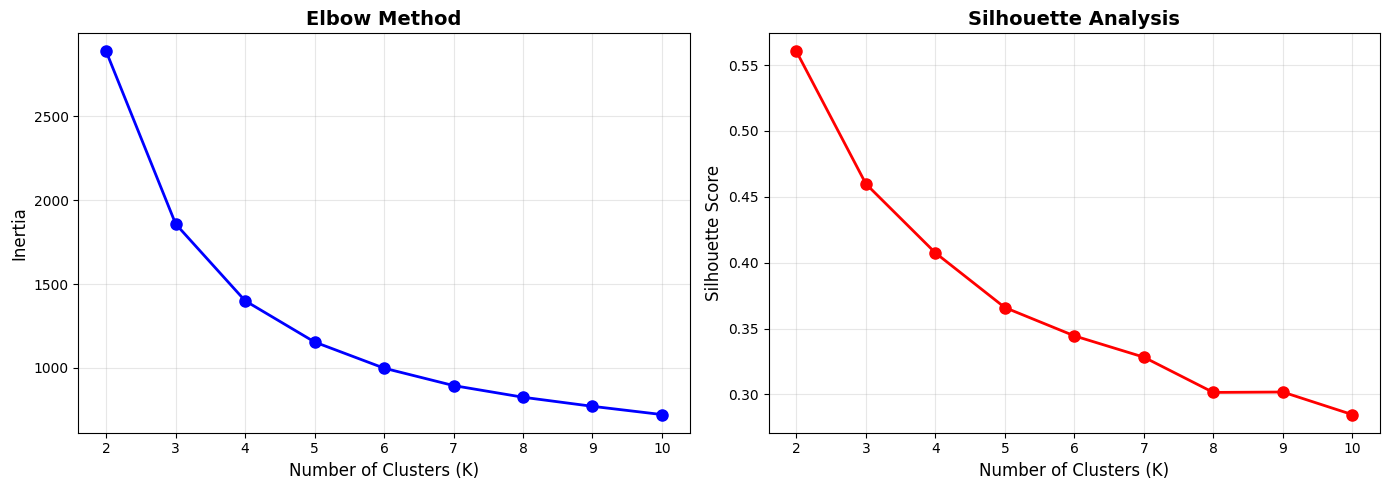

In [ ]:
# can skip this block; we know optimal clusters is 5

from sklearn.metrics import silhouette_score

# find optimal number of clusters
inertias = []
silhouettes = []
K_range = range(2, 11)

print("Testing different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_data)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_data, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouettes[-1]:.3f}")

# plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# fit k-means
k = 5

print(f"\nfitting k-means with k={k} clusters...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster_old'] = kmeans.fit_predict(X_data)

# pca
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_data)
df['pc1'] = pca_coords[:, 0]
df['pc2'] = pca_coords[:, 1]

print(f"pca explained variance: pc1={pca.explained_variance_ratio_[0]:.1%}, pc2={pca.explained_variance_ratio_[1]:.1%}")
print(f"total variance captured: {sum(pca.explained_variance_ratio_):.1%}")

# analyze and rank clusters
cluster_info = []

print(f"\n{'old cluster':<12} | {'end pace':<10} | {'fade %':<10}")
print("-" * 50)

for i in range(k):
    cluster_profile = X_data[df['cluster_old'] == i].mean(axis=0)
    end_pace = cluster_profile.iloc[-1]
    fade_pct = (end_pace - 1.0) * 100
    cluster_info.append((i, end_pace, fade_pct))
    print(f"{i:<12} | {end_pace:<10.3f} | {fade_pct:<10.1f}%")

cluster_info.sort(key=lambda x: x[1])

old_to_new = {}
new_to_label = {
    1: "cluster 1: even pacing",
    2: "cluster 2: mild slowing",
    3: "cluster 3: moderate slowing",
    4: "cluster 4: significant slowing",
    5: "cluster 5: severe crash"
}

print(f"\n{'new #':<8} | {'old #':<8} | {'end pace':<10} | {'fade %':<10} | {'label'}")
print("-" * 80)

for new_num, (old_num, end_pace, fade_pct) in enumerate(cluster_info, start=1):
    old_to_new[old_num] = new_num
    label = new_to_label[new_num]
    print(f"{new_num:<8} | {old_num:<8} | {end_pace:<10.3f} | {fade_pct:<10.1f}% | {label}")

# apply renumbering
df['cluster'] = df['cluster_old'].map(old_to_new)
df['cluster_name'] = df['cluster'].map(new_to_label)

print("\nfinal distribution (new numbering):")
for i in range(1, 6):
    count = (df['cluster'] == i).sum()
    pct = (count / len(df)) * 100
    print(f"  {new_to_label[i]}: {count:,} ({pct:.1f}%)")


fitting k-means with k=5 clusters...
pca explained variance: pc1=91.7%, pc2=6.0%
total variance captured: 97.8%

old cluster  | end pace   | fade %    
--------------------------------------------------
0            | 0.996      | -0.4      %
1            | 1.132      | 13.2      %
2            | 1.365      | 36.5      %
3            | 1.221      | 22.1      %
4            | 1.058      | 5.8       %

new #    | old #    | end pace   | fade %     | label
--------------------------------------------------------------------------------
1        | 0        | 0.996      | -0.4      % | cluster 1: even pacing
2        | 4        | 1.058      | 5.8       % | cluster 2: mild slowing
3        | 1        | 1.132      | 13.2      % | cluster 3: moderate slowing
4        | 3        | 1.221      | 22.1      % | cluster 4: significant slowing
5        | 2        | 1.365      | 36.5      % | cluster 5: severe crash

final distribution (new numbering):
  cluster 1: even pacing: 14,585 (25.9%)
  clust

Visualizations

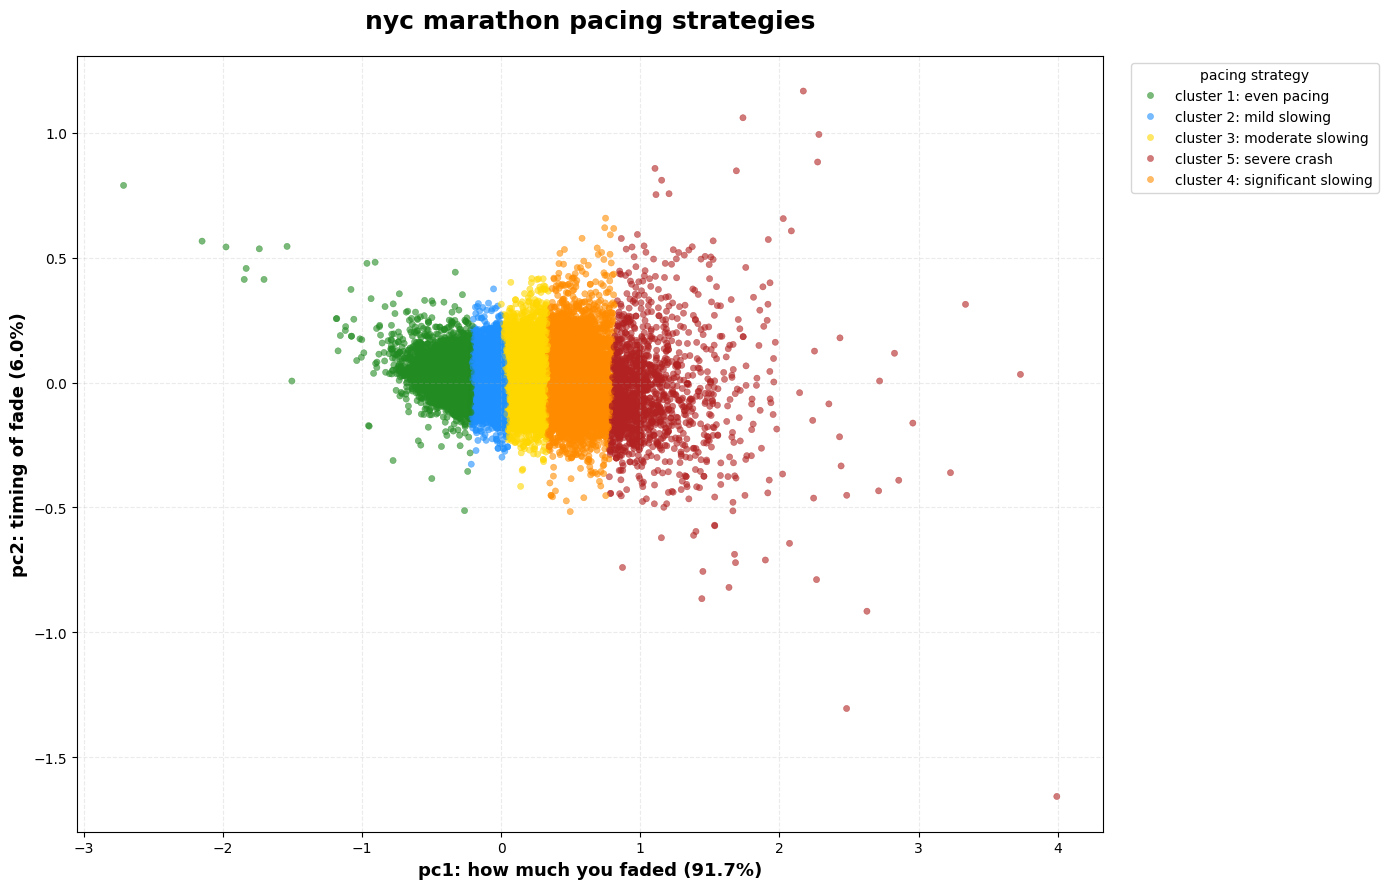

In [ ]:
color_map = {
    'cluster 1: even pacing': 'forestgreen',
    'cluster 2: mild slowing': 'dodgerblue',
    'cluster 3: moderate slowing': 'gold',
    'cluster 4: significant slowing': 'darkorange',
    'cluster 5: severe crash': 'firebrick'
}

plt.figure(figsize=(14, 9))
sns.scatterplot(
    x='pc1', y='pc2',
    hue='cluster_name',
    data=df,
    palette=color_map,
    alpha=0.6,
    s=20,
    edgecolor=None
)

plt.title('nyc marathon pacing strategies', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('pc1: how much you faded (91.7%)', fontsize=13, fontweight='bold')
plt.ylabel('pc2: timing of fade (6.0%)', fontsize=13, fontweight='bold')
plt.legend(title='pacing strategy', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()

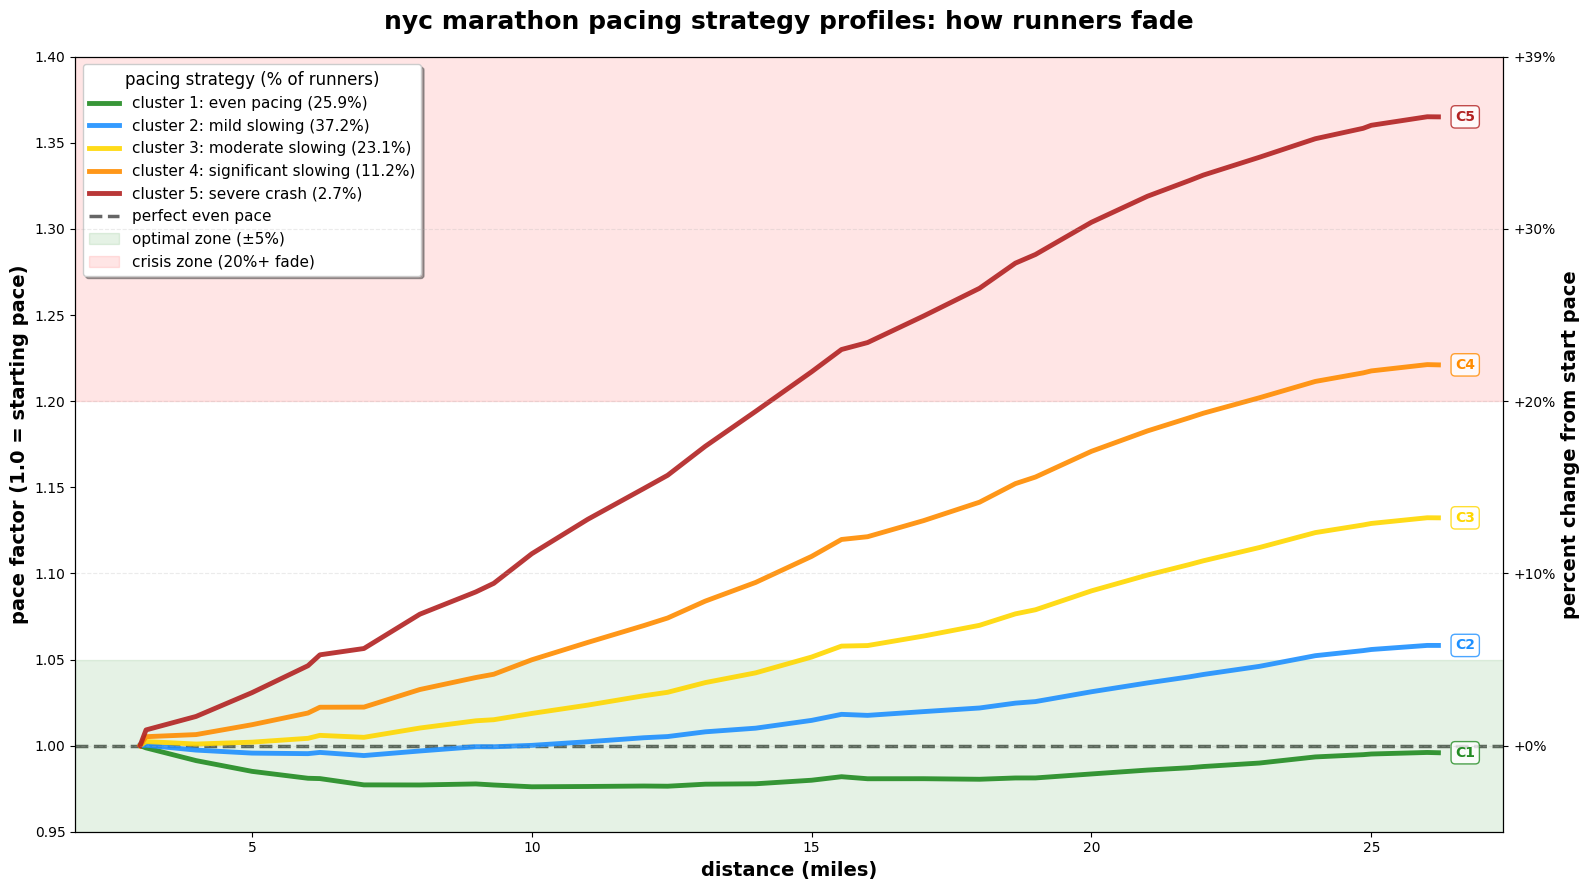

In [ ]:
plt.figure(figsize=(16, 9))

cluster_order = sorted(df['cluster'].unique())

for new_num in cluster_order:
    label = new_to_label[new_num]
    color = color_map.get(label, 'gray')

    profile = X_data[df['cluster'] == new_num].mean(axis=0)
    cluster_size = (df['cluster'] == new_num).sum()
    cluster_pct = (cluster_size / len(df)) * 100

    # label with percentage
    display_label = f"{label} ({cluster_pct:.1f}%)"

    plt.plot(distances, profile, label=display_label, color=color, linewidth=3.5, alpha=0.9)

    plt.text(distances[-1] + 0.3, profile.iloc[-1],
             f"C{new_num}",
             fontsize=10, color=color, fontweight='bold',
             va='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.axhline(1.0, color='black', linestyle='--', linewidth=2.5, alpha=0.6,
            label='perfect even pace', zorder=0)

# shaded zones
plt.axhspan(0.95, 1.05, alpha=0.1, color='green', zorder=0, label='optimal zone (±5%)')
plt.axhspan(1.20, 1.50, alpha=0.1, color='red', zorder=0, label='crisis zone (20%+ fade)')

plt.title('nyc marathon pacing strategy profiles: how runners fade',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('distance (miles)', fontsize=14, fontweight='bold')
plt.ylabel('pace factor (1.0 = starting pace)', fontsize=14, fontweight='bold')

ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('percent change from start pace', fontsize=14, fontweight='bold')

y_ticks = ax.get_yticks()
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([f'{int((y-1)*100):+d}%' for y in y_ticks])

plt.grid(True, alpha=0.25, linestyle='--')
plt.ylim(0.95, 1.40)
ax.set_ylim(0.95, 1.40)

ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True,
          title='pacing strategy (% of runners)', title_fontsize=12)

plt.tight_layout()
plt.show()